In [1]:
# !pip install git+https://github.com/tsproisl/textcomplexity.git
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

from textcomplexity.utils.conllu import read_conllu_sentences
from textcomplexity.dependency import (
    average_dependency_distance,
    longest_shortest_path,
    closeness_centralization,
    outdegree_centralization,
)

In [2]:
def run_txtcomplexity(path):
    graphs = []
    with open(path, encoding="utf-8") as f:
        for tokens, g in read_conllu_sentences(f):
            graphs.append(g)

    if not graphs:
        return {}

    add_mean, _    = average_dependency_distance(graphs)
    depth_mean, _  = longest_shortest_path(graphs)
    clos_mean, _   = closeness_centralization(graphs)
    outdeg_mean, _ = outdegree_centralization(graphs)

    return {
        "average_dependency_distance": add_mean,
        "longest_shortest_path":       depth_mean,
        "closeness_centralization":    clos_mean,
        "outdegree_centralization":    outdeg_mean,
    }

In [3]:
DATA_DIR = r"/home/cometbridge1998/Documents/SUDcom/dataset/tagged-stanza"
ud_files = {os.path.splitext(os.path.basename(f))[0].replace("UD_", ""): f
            for f in glob.glob(os.path.join(DATA_DIR, "UD", "*.conllu"))}

sud_files = {os.path.splitext(os.path.basename(f))[0].replace("SUD_", ""): f
             for f in glob.glob(os.path.join(DATA_DIR, "SUD", "*.conllu"))}

print("UD files:", len(ud_files))
print("SUD files:", len(sud_files))

pairs = [(ud_files[k], sud_files[k]) for k in sorted(set(ud_files) & set(sud_files))]
print("Found pairs:", len(pairs))

UD files: 1488
SUD files: 1488
Found pairs: 1488


In [4]:
rows = []
for ud, sud in pairs:
    key = os.path.splitext(os.path.basename(ud))[0]

    print(f"running {key}")

    level = key.split("_")[0]                        
    m_ud = run_txtcomplexity(ud)
    m_sud = run_txtcomplexity(sud)
    rows.append({
        "id": key,
        "level": level,
        "depth_ud": m_ud["longest_shortest_path"],
        "depth_sud": m_sud["longest_shortest_path"],
        "add_ud": m_ud["average_dependency_distance"],
        "add_sud": m_sud["average_dependency_distance"],
        "clos_cent_ud": m_ud["closeness_centralization"],
        "clos_cent_sud": m_sud["closeness_centralization"],
        "outdeg_cent_ud": m_ud["outdegree_centralization"],
        "outdeg_cent_sud": m_sud["outdegree_centralization"],
    })

df = pd.DataFrame(rows)
df.to_csv("ud_sud_metrics.csv", index=False)
df.head()

running A1_0001
running A1_0002
running A1_0003
running A1_0004
running A1_0005
running A1_0006
running A1_0007
running A1_0008
running A1_0009
running A1_0010
running A1_0011
running A1_0012
running A1_0013
running A1_0014
running A1_0015
running A1_0016
running A1_0017
running A1_0018
running A1_0019
running A1_0020
running A1_0021
running A1_0022
running A1_0023
running A1_0024
running A1_0025
running A1_0026
running A1_0027
running A1_0028
running A1_0029
running A1_0030
running A1_0031
running A1_0032
running A1_0033
running A1_0034
running A1_0035
running A1_0036
running A1_0037
running A1_0038
running A1_0039
running A1_0040
running A1_0041
running A1_0042
running A1_0043
running A1_0044
running A1_0045
running A1_0046
running A1_0047
running A1_0048
running A1_0049
running A1_0050
running A1_0051
running A1_0052
running A1_0053
running A1_0054
running A1_0055
running A1_0056
running A1_0057
running A1_0058
running A1_0059
running A1_0060
running A1_0061
running A1_0062
running 

,id,level,depth_ud,depth_sud,add_ud,add_sud,clos_cent_ud,clos_cent_sud,outdeg_cent_ud,outdeg_cent_sud
0,A1_0001,A1,2.071429,2.785714,2.240363,2.030272,0.717981,0.599505,0.655822,0.543706
1,A1_0002,A1,1.708333,2.458333,2.017113,1.926935,0.780911,0.649952,0.733781,0.601452
2,A1_0003,A1,2.142857,3.214286,2.256526,2.241309,0.707667,0.576349,0.645759,0.533292
3,A1_0004,A1,1.941176,2.411765,2.149860,2.029762,0.718731,0.638543,0.651029,0.575408
4,A1_0005,A1,2.687500,3.750000,2.416122,2.159966,0.606831,0.504484,0.548538,0.466904


In [5]:
def test_metric(col_ud, col_sud, name):
    x, y = df[col_ud], df[col_sud]
    stat, p = wilcoxon(x, y)
    print(f"{name}: mean UD={x.mean():.3f}, mean SUD={y.mean():.3f}, p={p:.4g}")

print("Hypothesis tests:")
test_metric("depth_ud","depth_sud","(a) Tree depth")
test_metric("add_ud","add_sud","(b) Avg dependency distance")
test_metric("clos_cent_ud","clos_cent_sud","(c1) Closeness centralization")
test_metric("outdeg_cent_ud","outdeg_cent_sud","(c2) Outdegree centralization")


Hypothesis tests:
(a) Tree depth: mean UD=3.839, mean SUD=5.602, p=9.102e-245
(b) Avg dependency distance: mean UD=2.872, mean SUD=2.589, p=1.739e-242
(c1) Closeness centralization: mean UD=0.496, mean SUD=0.391, p=9.137e-245
(c2) Outdegree centralization: mean UD=0.389, mean SUD=0.324, p=1.336e-242


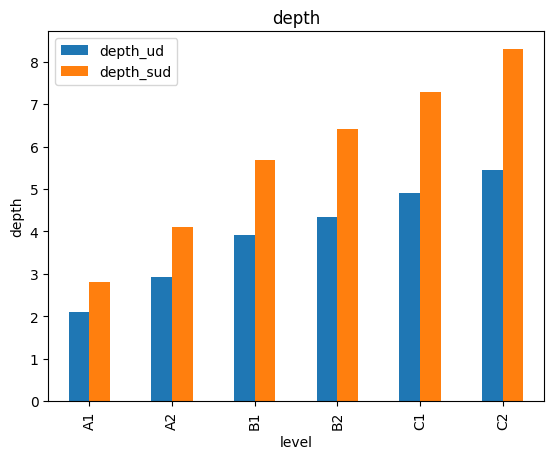

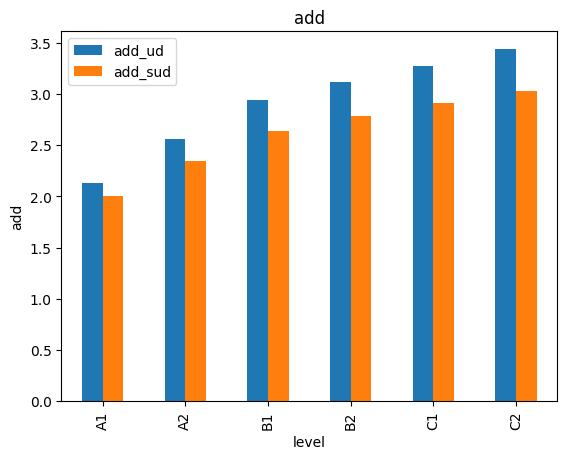

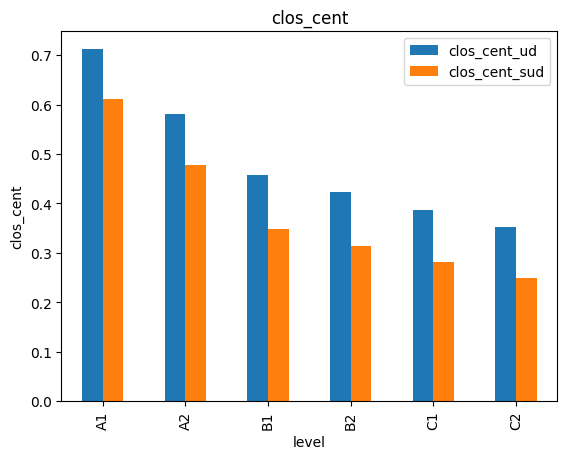

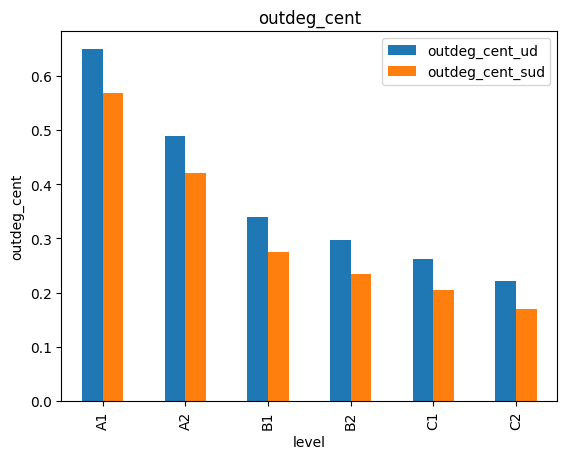

In [7]:
for metric in ["depth", "add", "clos_cent", "outdeg_cent"]:
    means = df.groupby("level")[[f"{metric}_ud", f"{metric}_sud"]].mean()
    means.plot.bar(title=metric)
    plt.ylabel(metric)
    plt.savefig(f'Illustrations/results/{metric}.png')
    plt.show()